<h1>Convolutional Neural Networks using PyTorch Library</h1>
We import torchvision in order to load the dataset(CIFAR10).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Device configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Hyperparameters<br>
input size is 28x28

In [3]:
num_epochs = 4
batch_size = 4
learning_rate = 0.001

CIFAR10 dataset<br>
Note: dataset has PIL format images with range [0,1], so we use <br>
transforms.ToTensor() to convert them to range [-1,1]

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./datasetCIFAR10', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./datasetCIFAR10', train=False, transform=transform)

Files already downloaded and verified


Loading the dataset<br>
Note: We dont shuffle the test set because it doesn't matter for evaluation.

In [5]:
train_dataset_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Lets explore the dataset<br>
torch.Size([100, 1, 28, 28]) - means 100 images of 1 channel and 28x28 pixels<br>
torch.Size([100]) - means 100 labels

In [6]:
data = iter(train_dataset_loader)
images, labels = data.next()
print(images.shape)
print(labels.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4])


Plot some of the images in the dataset<br>
images[i][0] - image I and channel 0<br>
subplot(x, y, index) - x and y are the number of rows and columns in the plot

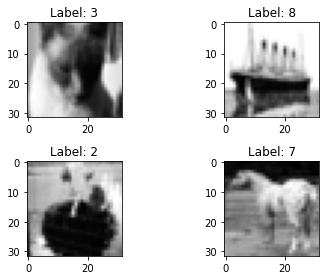

In [7]:
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray')
    plt.title("Label: {}".format(labels[i]))

Hard coding the classes information

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Creating our Convolutional Neural Network<br>
We have to implement class that derives from torch.nn.Module<br>
<!-- Note: we don't apply softmax to the output of the last layer because we will use cross-entropy loss. -->

In [9]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        # input_size = 3*32*32
        self.conv1 = nn.Conv2d(3, 6, 5) # after conv1, output_size = 6*28*28
        self.pool = nn.MaxPool2d(2, 2) # after pool, output_size = 6*14*14
        self.conv2 = nn.Conv2d(6, 16, 5) # after conv2, output_size = 16*10*10
        self.fc1 = nn.Linear(16*5*5, 120) # after fc1(fully connected)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Model, Loss and Optimizer (SGD - Stochastic Gradient Descent)

In [10]:
model = ConvNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Training the Model

In [11]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataset_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad() # clear gradients for this training step
        loss.backward() # backpropagation, compute gradients
        optimizer.step() # update step and updates some parameters, apply gradients

        if (i+1) % 1000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                  .format(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))

Epoch [1/4], Step [100/12500], Loss: 2.2749
Epoch [1/4], Step [200/12500], Loss: 2.3748
Epoch [1/4], Step [300/12500], Loss: 2.2987
Epoch [1/4], Step [400/12500], Loss: 2.2796
Epoch [1/4], Step [500/12500], Loss: 2.3092
Epoch [1/4], Step [600/12500], Loss: 2.2872
Epoch [1/4], Step [700/12500], Loss: 2.2952
Epoch [1/4], Step [800/12500], Loss: 2.3045
Epoch [1/4], Step [900/12500], Loss: 2.2744
Epoch [1/4], Step [1000/12500], Loss: 2.3462
Epoch [1/4], Step [1100/12500], Loss: 2.3461
Epoch [1/4], Step [1200/12500], Loss: 2.3036
Epoch [1/4], Step [1300/12500], Loss: 2.3297
Epoch [1/4], Step [1400/12500], Loss: 2.2849
Epoch [1/4], Step [1500/12500], Loss: 2.3871
Epoch [1/4], Step [1600/12500], Loss: 2.3712
Epoch [1/4], Step [1700/12500], Loss: 2.3239
Epoch [1/4], Step [1800/12500], Loss: 2.3395
Epoch [1/4], Step [1900/12500], Loss: 2.2623
Epoch [1/4], Step [2000/12500], Loss: 2.2757
Epoch [1/4], Step [2100/12500], Loss: 2.2937
Epoch [1/4], Step [2200/12500], Loss: 2.2639
Epoch [1/4], Step [

Testing the Model

In [12]:
num_correct = 0
num_samples = 0
num_class_correct = [0 for i in range(10)]
num_class_samples = [0 for i in range(10)]
with torch.no_grad():
    for images, labels in test_dataset_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # values, indices
        _, predicted = torch.max(outputs, 1)
        
        num_correct += (predicted == labels).sum().item()
        num_samples += labels.shape[0]

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                num_class_correct[label] += 1
            num_class_samples[label] += 1
    
    acc = 100.0 * num_correct / num_samples
    print("Accuracy of the network on the cifar10 test images: {:.4f}".format(acc))

    for i in range(10):
        print("Accuracy of {}: {:.4f}".format(classes[i], 100.0 * num_class_correct[i] / num_class_samples[i]))


Accuracy of the network on the cifar10 test images: 46.6200
Accuracy of plane: 62.8000
Accuracy of car: 60.2000
Accuracy of bird: 27.3000
Accuracy of cat: 24.7000
Accuracy of deer: 22.1000
Accuracy of dog: 43.7000
Accuracy of frog: 80.4000
Accuracy of horse: 49.6000
Accuracy of ship: 36.6000
Accuracy of truck: 58.8000
